In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_chessboard_points():
    """
    This function
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    dim = (9,6)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

def calibrate_camera(img):
    """
    Calibrate the camera with the size respect to a particular image
    """
    objpoints, imgpoints = get_chessboard_points()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist

def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Just to combine the sobelx and S from HSL to do binary threshold of the img
    """
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def warped_bw(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
       
    # start from top-left and rotate clockwise
    src = np.float32([(585,440),(690,440),(1080,690),(215,690)])
    dst = np.float32([(0,0),(1280,0),(1080,720),(240,720)])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def lane_detection(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit

def visualize_things(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

def get_roc(leftx, rightx):
    ploty_left = np.linspace(0, 719, num=len(leftx))
    ploty_right = np.linspace(0, 719, num=len(rightx))

    y_eval = np.max(ploty_left)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty_left*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty_right*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])       
    
    lane_width = 3.7
    center_img = 650.0*xm_per_pix
    
    y_eval_m = np.max(ploty_left)*ym_per_pix
    
    leftx_line_pos = left_fit_cr[0]*y_eval_m**2 + left_fit_cr[1]*y_eval_m + left_fit_cr[2]
    rightx_line_pos = right_fit_cr[0]*y_eval_m**2 + right_fit_cr[1]*y_eval_m + right_fit_cr[2]
            
    center_line = rightx_line_pos-leftx_line_pos
    off_center = center_img - center_line
    
    return left_curverad, right_curverad, off_center

from numpy.linalg import inv

def plot_lane_boundaries(warped, ploty, left_fitx, right_fitx, mat, image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = inv(mat)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result

def plot_numerical_estimation(img, leftx, rightx):
    left_curv, right_curv, offset = get_roc(leftx, rightx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'left curve: {:5.1f}m '.format(left_curv),(50,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'right curve: {:5.1f}m '.format(right_curv),(50,150), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'offset: {:5.1f}m '.format(offset),(50,200), font, 1.5,(255,255,255),2,cv2.LINE_AA)


In [5]:
def get_matrices():
    # just read in a dummy image, so that it detects the correct sizes of the images
    straight_images = glob.glob('../test_images/straight_*.jpg')
    fname = straight_images[0]
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, camera_mat, dist_mat = calibrate_camera(img)
    
    return camera_mat, dist_mat

In [6]:
def big_pipeline(img):
    binary_img = pipeline(img)
    binary_warped, trans_mat = warped_bw(binary_img)
    leftx, lefty, rightx, righty, left_fit, right_fit = lane_detection(binary_warped)
    ploty, left_fitx, right_fitx = visualize_things(binary_warped, left_fit, right_fit)
    res = plot_lane_boundaries(binary_warped, ploty, left_fitx, right_fitx, trans_mat, img)
    plot_numerical_estimation(res, leftx, rightx)
    return res

In [1]:
import numpy as np
# Define a class to receive the characteristics of each line detection
# make this left/right compatible
class Line():
    def __init__(self):
        self.n = 6
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def cal_avgx(self):
        self.bestx = np.mean(self.recent_xfitted)
        
    def add_recentxfit(self):

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


  3%|▎         | 32/1261 [00:03<02:09,  9.50it/s]Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x7f1a6d525c88>>
Traceback (most recent call last):
  File "/home/robtf/anaconda3/lib/python3.5/site-packages/moviepy/video/io/VideoFileClip.py", line 90, in __del__
    del self.reader
AttributeError: reader
 46%|████▌     | 578/1261 [01:04<01:15,  9.06it/s]Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x7f1a6d856f98>>
Traceback (most recent call last):
  File "/home/robtf/anaconda3/lib/python3.5/site-packages/moviepy/video/io/VideoFileClip.py", line 90, in __del__
    del self.reader
AttributeError: reader
100%|█████████▉| 1260/1261 [02:19<00:00,  8.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 10min 51s, sys: 2min 14s, total: 13min 5s
Wall time: 2min 20s


NameError: name 'HTML' is not defined

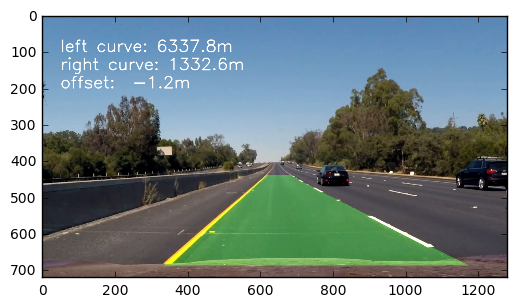

In [10]:
output = 'out_project_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(big_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))